In [1]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

self_tuning = 1
Uncertainty = 0
switching = 0
dist = 0

import sys
from math import isnan, pi
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

plt.close('all')

import torch
import torch.nn as nn
import torch.optim as optim

from utils.Quadcopter_Dynamics import Quadcopter_Dynamics_with_Disturbance, Add_Noise
from utils.A2C_models.A2C_model import NewAgent
from utils import QuadParams
from utils.util_functions import Saturation, Reward, reset_parameters, reset_params
from utils.SMC_Controller import SMC

Parameters = QuadParams

In [2]:
class my_struct:
    min = 0
    max = 0


def GainBound(static_gain, coef1=0.3, coef2=2):
    out = my_struct()
    out.min, out.max = static_gain * coef1, static_gain * coef2
    return out


global dt, T, Tf

In [3]:
# -------------------  Model Dynamics Parameters  ---------------------------------#
print("Model Parameters ...")
global m, g
global l, b, d
global Jx, Jy, Jz
global a1, a2, a3
global b1, b2, b3

m, g, l = Parameters.m, Parameters.g, Parameters.l
Jx, Jy, Jz = Parameters.Jx, Parameters.Jy, Parameters.Jz
b, d = Parameters.b, Parameters.d
a1, a2, a3 = Parameters.a1, Parameters.a2, Parameters.a3
b1, b2, b3 = Parameters.b1, Parameters.b2, Parameters.b3

print("Initialize Requirements ...")
dt = 0.01
T = dt
Tf = 20
t = np.arange(0, Tf + dt, dt)
N = int(Tf / dt) + 1
n = 12 + 3
x0 = np.zeros((n, 1))
x = x0
Xs = np.zeros((N + 1, n))
y = np.zeros((6, 1))
Uxy = np.array([0, 0])

U = np.zeros((1, 4))
u = np.zeros((4, 1))

Xd = np.zeros((N + 1, n))
Xm = np.zeros((N + 1, n))
m0 = m
M = m0 * np.ones((N + 1, 1))

Model Parameters ...
Initialize Requirements ...


In [4]:
# ------------Reinforcement Learning Parameters ---------------------------------
# Value functions------------ Rewards---------------Temporal differense Error----
V_z = np.zeros((N + 1, 1))
R_z = np.zeros((N + 1, 1))
delta_z = np.zeros((N + 1, 1))
V_phi = np.zeros((N + 1, 1))
R_phi = np.zeros((N + 1, 1))
delta_phi = np.zeros((N + 1, 1))
V_tta = np.zeros((N + 1, 1))
R_tta = np.zeros((N + 1, 1))
delta_tta = np.zeros((N + 1, 1))
V_psi = np.zeros((N + 1, 1))
R_psi = np.zeros((N + 1, 1))
delta_psi = np.zeros((N + 1, 1))


In [5]:
# ------Track a Constant point in 3D world
# Xd[:-1, 6] = 1
# Xd[:-1, 8] = 1
# Xd[:-1,10] = 3

# ------- Track a Square path in a constant altitude in 3D world
Xd[:-1, 4] = np.deg2rad(10 * signal.square(5 * np.pi / Tf * t))
Xd[:, 6] = 1
Xd[:-1, 8] = 1 + signal.square(4 * np.pi / Tf * t)
Xd[:-1, 10] = 1 + signal.square(4 * np.pi / Tf * (t - Tf / 8))

# ----Track a Helical path in 3D world
# Xd[:-1,  4] = np.deg2rad(np.sin(5*np.pi/Tf*t))
# Xd[:-1,  6] = 0.05*t
# Xd[:-1,  8] = np.cos(4*np.pi/Tf*t)  
# Xd[:-1, 10] = np.sin(4*np.pi/Tf*t)


# ----Track a Circular path in 3D world
# radius = 2  # Radius of the circle
# center_x = 1  # Center of the circle in X
# center_y = 1  # Center of the circle in Y
# Xd[:-1, 8] = center_x + radius * np.cos(2 * np.pi / Tf * t)  # X position
# Xd[:-1, 10] = center_y + radius * np.sin(2 * np.pi / Tf * t)  # Y position
# Xd[:-1, 6] = 1  # Z position (altitude remains constant at 1)


# ----Track a Parabolic path in 3D world
# a = 0.05  # Coefficient for the parabolic curve
# Xd[:-1, 8] = 1  # X position (constant)
# Xd[:-1, 10] = 1  # Y position (constant)
# Xd[:-1, 6] = a * (t - Tf/2)**2  # Parabolic trajectory in Z


# Track a Sinusoidal Path in 3D world
# amplitude = 1
# frequency = 0.5
# Xd[:-1, 8] = amplitude * np.sin(2 * np.pi * frequency * t)  # X position
# Xd[:-1, 10] = amplitude * np.sin(2 * np.pi * frequency * t)  # Y position
# Xd[:-1, 6] = amplitude * np.sin(2 * np.pi * frequency * t)  # Z position


# Subsystems bounds for z
Sigma_domain_z = 0.5
Sigma_domain_phi, Sigma_domain_tta, Sigma_domain_psi = pi / 36.0, pi / 36.0, pi / 36.0


ValueError: could not broadcast input array from shape (2002,) into shape (2001,)

#  PID Control Initialization

In [ ]:
# -----------------  Static Gains   -----------------------------------#

print("Initialize PID Params ...")
Kp_x_static = 7 * 3.1415 / 180
Ki_x_static = 0
Kd_x_static = 7 * 3.1415 / 180

Kp_y_static = 7 * 3.1415 / 180
Ki_y_static = 0
Kd_y_static = 7 * 3.1415 / 180

Kp_z_static = 15
Ki_z_static = 2
Kd_z_static = 15

Kp_psi_static = 3.0
Ki_psi_static = 0.0
Kd_psi_static = 0.3

Kp_phi_static = 0.5
Ki_phi_static = 0.0
Kd_phi_static = 0.2

Kp_tta_static = 0.5
Ki_tta_static = 0.0
Kd_tta_static = 0.2

Initialize PID Params ...


In [ ]:
# -------------------    Dynamic Gains  ------------------------------------#

Kp_x_dynamic = np.zeros((N + 1, 1))
Ki_x_dynamic = np.zeros((N + 1, 1))
Kd_x_dynamic = np.zeros((N + 1, 1))

Kp_y_dynamic = np.zeros((N + 1, 1))
Ki_y_dynamic = np.zeros((N + 1, 1))
Kd_y_dynamic = np.zeros((N + 1, 1))

Kp_z_dynamic = np.zeros((N + 1, 1))
Ki_z_dynamic = np.zeros((N + 1, 1))
Kd_z_dynamic = np.zeros((N + 1, 1))

Kp_psi_dynamic = np.zeros((N + 1, 1))
Ki_psi_dynamic = np.zeros((N + 1, 1))
Kd_psi_dynamic = np.zeros((N + 1, 1))

Kp_phi_dynamic = np.zeros((N + 1, 1))
Ki_phi_dynamic = np.zeros((N + 1, 1))
Kd_phi_dynamic = np.zeros((N + 1, 1))

Kp_tta_dynamic = np.zeros((N + 1, 1))
Ki_tta_dynamic = np.zeros((N + 1, 1))
Kd_tta_dynamic = np.zeros((N + 1, 1))

In [ ]:
# ------------------  Main Gains  -------------------------------------#
Kp_x = np.zeros((N + 1, 1))
Kp_x_min = 0
Kp_x_max = 2 * Kp_x_static
Ki_x = np.zeros((N + 1, 1))
Ki_x_min = 0
Ki_x_max = 2 * Ki_x_static
Kd_x = np.zeros((N + 1, 1))
Kd_x_min = 0
Kd_x_max = 2 * Kd_x_static

Kp_y = np.zeros((N + 1, 1))
Kp_y_min = 0
Kp_y_max = 2 * Kp_y_static
Ki_y = np.zeros((N + 1, 1))
Ki_y_min = 0
Ki_y_max = 2 * Ki_y_static
Kd_y = np.zeros((N + 1, 1))
Kd_y_min = 0
Kd_y_max = 2 * Kd_y_static

Kp_z = np.zeros((N + 1, 1))
Kp_z_min = 0
Kp_z_max = 2 * Kp_z_static
Ki_z = np.zeros((N + 1, 1))
Ki_z_min = 0
Ki_z_max = 2 * Ki_z_static
Kd_z = np.zeros((N + 1, 1))
Kd_z_min = 0
Kd_z_max = 2 * Kd_z_static

Kp_psi = np.zeros((N + 1, 1))
Kp_psi_min = 0
Kp_psi_max = 2 * Kp_psi_static
Ki_psi = np.zeros((N + 1, 1))
Ki_psi_min = 0
Ki_psi_max = 2 * Ki_psi_static
Kd_psi = np.zeros((N + 1, 1))
Kd_psi_min = 0
Kd_psi_max = 2 * Kd_psi_static

Kp_phi = np.zeros((N + 1, 1))
Kp_phi_min = 0
Kp_phi_max = 2 * Kp_phi_static
Ki_phi = np.zeros((N + 1, 1))
Ki_phi_min = 0
Ki_phi_max = 2 * Ki_phi_static
Kd_phi = np.zeros((N + 1, 1))
Kd_phi_min = 0
Kd_phi_max = 2 * Kd_phi_static

Kp_tta = np.zeros((N + 1, 1))
Kp_tta_min = 0
Kp_tta_max = 2 * Kp_tta_static
Ki_tta = np.zeros((N + 1, 1))
Ki_tta_min = 0
Ki_tta_max = 2 * Ki_tta_static
Kd_tta = np.zeros((N + 1, 1))
Kd_tta_min = 0
Kd_tta_max = 2 * Kd_tta_static

e1 = np.zeros((N + 1, n))
e2 = np.zeros((N + 1, n))


In [ ]:
# ---------------------   Initialize Control inputs  ----------------------------------------#
u1 = np.zeros((N + 1, 1))
u2 = np.zeros((N + 1, 1))
u3 = np.zeros((N + 1, 1))
u4 = np.zeros((N + 1, 1))
tta_d = np.zeros((N + 1, 1))
phi_d = np.zeros((N + 1, 1))

In [ ]:
# Reset Integrator terms
ei_psi = 0
ei_phi = 0
ei_tta = 0
ei_z = 0
ei_x = 0
ei_y = 0

In [ ]:
# %%
K_z_static = torch.tensor([[Kp_z_static, Ki_z_static, Kd_z_static]], dtype=torch.float32)
K_phi_static = torch.tensor([[Kp_phi_static, Ki_phi_static, Kd_phi_static]], dtype=torch.float32)
K_tta_static = torch.tensor([[Kp_tta_static, Ki_tta_static, Kd_tta_static]], dtype=torch.float32)
K_psi_static = torch.tensor([[Kp_psi_static, Ki_psi_static, Kd_psi_static]], dtype=torch.float32)

K_z_domain = 0.5 * K_z_static
K_phi_domain = 0.5 * torch.tensor([[Kp_phi_static, 0.1, Kd_phi_static]], dtype=torch.float32)  # 0.5*K_phi_static
K_tta_domain = 0.5 * torch.tensor([[Kp_tta_static, 0.1, Kd_tta_static]], dtype=torch.float32)  # 0.5*K_tta_static
K_psi_domain = 0.5 * torch.tensor([[Kp_psi_static, 0.1, Kd_psi_static]], dtype=torch.float32)  # 0.5*K_psi_static

In [ ]:
# %% Actor & Critic Structures
print("Create Network structures ...\n")
# ----------------------------- Z Actor Critic ------------------------------------------------------#
z_agent = NewAgent(state_size=7, hidden_size=5, alpha=0.01, gamma=0.99, K_static=K_z_static, K_domain=K_z_domain,
                   Sigma_domain=Sigma_domain_z)
z_agent = reset_params(z_agent, init_type="uniform")

# ----------------------------- Phi Actor Critic ------------------------------------------------------#
phi_agent = NewAgent(state_size=7, hidden_size=5, alpha=0.0001, gamma=0.99, K_static=K_phi_static,
                     K_domain=K_phi_domain, Sigma_domain=Sigma_domain_phi)
phi_agent = reset_params(phi_agent, init_type="uniform")

# ----------------------------- Tta Actor Critic ------------------------------------------------------#
tta_agent = NewAgent(state_size=7, hidden_size=5, alpha=0.0001, gamma=0.99, K_static=K_tta_static,
                     K_domain=K_tta_domain, Sigma_domain=Sigma_domain_tta)
tta_agent = reset_params(tta_agent, init_type="uniform")

# ----------------------------- Psi Actor Critic ------------------------------------------------------#
psi_agent = NewAgent(state_size=7, hidden_size=5, alpha=0.001, gamma=0.99, K_static=K_psi_static, K_domain=K_psi_domain,
                     Sigma_domain=Sigma_domain_psi)
psi_agent = reset_params(psi_agent, init_type="uniform")

Create Network structures ...



In [ ]:
# %%-------------- additional params ------------------
z_m = np.array([])
psi_m = np.array([])
phi_m = np.array([])
tta_m = np.array([])

mu_z = np.array([])
mu_psi = np.array([])
mu_phi = np.array([])
mu_tta = np.array([])

sigma_z = np.array([])
sigma_psi = np.array([])
sigma_phi = np.array([])
sigma_tta = np.array([])

# ---------------- Initiate loss functions ---------------#
z_agent_losses = np.array([])
phi_agent_losses = np.array([])
tta_agent_losses = np.array([])
psi_agent_losses = np.array([])

In [ ]:
# %%
# ---------------------------------------------  Main Loop  ----------------------------------------------#
print("Processing(Main Loop) ...\n")
ep_z = 0
ep_phi = 0
ep_tta = 0
ep_psi = 0

s_z = np.zeros((N + 1, 1))
s_phi = np.zeros((N + 1, 1))
s_tta = np.zeros((N + 1, 1))
s_psi = np.zeros((N + 1, 1))

p = int(Tf / dt)
for k in range(N):

    # ---------------------  Add Uncertainty to model  ----------------------------#
    # if Uncertainty==1:
    #     if k > int(Tf/3/dt):
    #         m = 0.65*2 
    #     if k > int(2*Tf/3/dt):
    #         m = 0.65*3
    m = m0
    if Uncertainty == 1:
        m = m0 * (0 <= k < int(0.2 * p)) + 2 * m0 * (int(0.2 * p) <= k < int(0.4 * p)) + \
            3 * m0 * (int(0.4 * p) <= k < int(0.6 * p)) + 2 * m0 * (int(0.6 * p) <= k < int(0.8 * p)) + \
            m0 * (int(0.8 * p) <= k < int(1.0 * p) + 1)

    M[k, :] = m
    ## ---------  Sliding Mode Control
    # [us, Uxy] = SMC(t[k], x, y, Uxy, m)
    # u = us

    # Self-tuning PID Control
    u[0] = u1[k]
    u[1] = u2[k]
    u[2] = u3[k]
    u[3] = u4[k]

    # Dynamic + Noise
    k1 = Quadcopter_Dynamics_with_Disturbance(0, x, u, m, dist, k)
    k2 = Quadcopter_Dynamics_with_Disturbance(0, x + dt / 2 * k1, u, m, dist, k)
    k3 = Quadcopter_Dynamics_with_Disturbance(0, x + dt / 2 * k2, u, m, dist, k)
    k4 = Quadcopter_Dynamics_with_Disturbance(0, x + dt * k3, u, m, dist, k)

    x = x + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    y = Quadcopter_Dynamics_with_Disturbance(0, x, u, m, dist, k)
    y = y[0::2]

    # Add Noise to outputs
    # x[4]   = Add_Noise(x[4], "Angular")
    # x[6:12:2] = Add_Noise(x[6:12:2], "Linear")

    Xs[k + 1, :] = x.T
    U = np.append(U, u.T, axis=0)

    # Desired X, Y
    Xd[k + 1, 0] = phi_d[k]
    Xd[k + 1, 1] = 0
    Xd[k + 1, 2] = tta_d[k]
    Xd[k + 1, 3] = 0
    if k > 0:
        Xd[k + 1, 1] = (phi_d[k] - phi_d[k - 1]) / dt
        Xd[k + 1, 3] = (tta_d[k] - tta_d[k - 1]) / dt

    ## Control Error
    e2[k + 1, :] = Xd[k + 1, :] - x.T

    # ------------------------------------    Config PID Errors   -------------------------------------------#
    ep_phi = e2[k, 0]
    ei_phi = ei_phi + ep_phi * dt
    ed_phi = e2[k, 1]

    ep_tta = e2[k, 2]
    ei_tta = ei_tta + ep_tta * dt
    ed_tta = e2[k, 3]

    ep_psi = e2[k, 4]
    ei_psi = ei_psi + ep_psi * dt
    ed_psi = e2[k, 5]

    ep_z = e2[k, 6]
    ei_z = ei_z + ep_z * dt
    ed_z = e2[k, 7]

    ep_x = e2[k, 8]
    ei_x = ei_x + ep_x * dt
    ed_x = e2[k, 9]

    ep_y = e2[k, 10]
    ei_y = ei_y + ep_y * dt
    ed_y = e2[k, 11]

    # %% Adaptive gains using Actor

    # ----------------------  Z network ----------------------
    z_state1 = torch.tensor([[u1[k][0], u1[k - 1][0], ep_z, ei_z, ed_z, Xs[k, 6], Xs[k - 1, 6]]], dtype=torch.float32)
    z_state2 = torch.tensor([[Xs[k, 6], Xs[k - 1, 6]]], dtype=torch.float32)
    z_target = Xs[k + 1, 6] * torch.ones((1, 1))

    z_agent.actor_critic.u.weight.data = torch.tensor([[ep_z, ei_z, ed_z]], dtype=torch.float32)
    z_output = z_agent.choose_action(z_state1, z_state2, z_target)
    z_m = np.append(z_m, z_output)

    # Extract dynamic gains    
    PID_gains_z = z_agent.actor_critic.PID()
    Kp_z[k + 1] = PID_gains_z[0][0].data.numpy()
    Ki_z[k + 1] = PID_gains_z[0][1].data.numpy()
    Kd_z[k + 1] = PID_gains_z[0][2].data.numpy()

    # -------------------------  PHI network -------------------------

    phi_state1 = torch.tensor([[u2[k][0], u2[k - 1][0], ep_phi, ei_phi, ed_phi, Xs[k, 0], Xs[k - 1, 0]]],
                              dtype=torch.float32)
    phi_state2 = torch.tensor([[Xs[k, 0], Xs[k - 1, 0]]], dtype=torch.float32)
    phi_target = Xs[k + 1, 0] * torch.ones((1, 1))

    phi_agent.actor_critic.u.weight.data = torch.tensor([[ep_phi, ei_phi, ed_phi]], dtype=torch.float32)
    phi_output = phi_agent.choose_action(phi_state1, phi_state2, phi_target)
    phi_m = np.append(phi_m, phi_output)

    # Extract dynamic gains    
    PID_gains_phi = phi_agent.actor_critic.PID()
    Kp_phi[k + 1] = PID_gains_phi[0][0].data.numpy()
    Ki_phi[k + 1] = PID_gains_phi[0][1].data.numpy()
    Kd_phi[k + 1] = PID_gains_phi[0][2].data.numpy()

    # ------------------------- TTA network ------------------------

    tta_state1 = torch.tensor([[u3[k][0], u3[k - 1][0], ep_tta, ei_tta, ed_tta, Xs[k, 2], Xs[k - 1, 2]]],
                              dtype=torch.float32)
    tta_state2 = torch.tensor([[Xs[k, 2], Xs[k - 1, 2]]], dtype=torch.float32)
    tta_target = Xs[k + 1, 2] * torch.ones((1, 1))

    tta_agent.actor_critic.u.weight.data = torch.tensor([[ep_tta, ei_tta, ed_tta]], dtype=torch.float32)
    tta_output = tta_agent.choose_action(tta_state1, tta_state2, tta_target)
    tta_m = np.append(tta_m, tta_output)

    # Extract dynamic gains   
    PID_gains_tta = tta_agent.actor_critic.PID()
    Kp_tta[k + 1] = PID_gains_tta[0][0].data.numpy()
    Ki_tta[k + 1] = PID_gains_tta[0][1].data.numpy()
    Kd_tta[k + 1] = PID_gains_tta[0][2].data.numpy()

    # -------------------------  PSI network ---------------------

    psi_state1 = torch.tensor([[u4[k][0], u4[k - 1][0], ep_psi, ei_psi, ed_psi, Xs[k, 4], Xs[k - 1, 4]]],
                              dtype=torch.float32)
    psi_state2 = torch.tensor([[Xs[k, 4], Xs[k - 1, 4]]], dtype=torch.float32)
    psi_target = Xs[k + 1, 4] * torch.ones((1, 1))

    psi_agent.actor_critic.u.weight.data = torch.tensor([[ep_psi, ei_psi, ed_psi]], dtype=torch.float32)
    psi_output = psi_agent.choose_action(psi_state1, psi_state2, psi_target)
    psi_m = np.append(psi_m, psi_output)

    # Extract dynamic gains    
    PID_gains_psi = psi_agent.actor_critic.PID()
    Kp_psi[k + 1] = PID_gains_psi[0][0].data.numpy()
    Ki_psi[k + 1] = PID_gains_psi[0][1].data.numpy()
    Kd_psi[k + 1] = PID_gains_psi[0][2].data.numpy()

    # ------------------------------------------- Adaptive PID Control   ------------------------------------#
    Kp_x[k + 1] = Kp_x_static
    Ki_x[k + 1] = Ki_x_static
    Kd_x[k + 1] = Kd_x_static
    Kp_y[k + 1] = Kp_y_static
    Ki_y[k + 1] = Ki_y_static
    Kd_y[k + 1] = Kd_y_static

    # ------------------  Update u(t)   --------------------------------------------#
    # U1 = z_agent.actor_critic.CtrlSignal()
    # u1[k+1] = U1[0][0].data.numpy()
    # uz = Kp_x[k+1]*ep_x + Ki_x[k+1]*ei_x + Kd_x[k+1]*ed_x
    # print(uz-u1[k+1])

    # U2 = phi_agent.actor_critic.CtrlSignal()
    # u2[k+1] = U2[0][0].data.numpy()

    # U3 = tta_agent.actor_critic.CtrlSignal()
    # u3[k+1] = U3[0][0].data.numpy()

    # U4 = psi_agent.actor_critic.CtrlSignal()
    # u4[k+1] = U4[0][0].data.numpy()

    u1[k + 1] = Kp_z[k + 1] * ep_z + Ki_z[k + 1] * ei_z + Kd_z[k + 1] * ed_z

    u2[k + 1] = Kp_phi[k + 1] * ep_phi + Ki_phi[k + 1] * ei_phi + Kd_phi[k + 1] * ed_phi

    u3[k + 1] = Kp_tta[k + 1] * ep_tta + Ki_tta[k + 1] * ei_tta + Kd_tta[k + 1] * ed_tta

    u4[k + 1] = Kp_psi[k + 1] * ep_psi + Ki_psi[k + 1] * ei_psi + Kd_psi[k + 1] * ed_psi

    tta_d[k + 1] = Kp_x[k + 1] * ep_x + Ki_x[k + 1] * ei_x + Kd_x[k + 1] * ed_x

    phi_d[k + 1] = -(Kp_y[k + 1] * ep_y + Ki_y[k + 1] * ei_y + Kd_y[k + 1] * ed_y)

    # -------------  Learn Actor & Critic  ------------------------------------#
    # ------- Z ------
    prediction_ = torch.tensor(z_output, dtype=torch.float32)
    reward = -(prediction_ - z_target) ** 2
    R_z[k, :] = reward.data.numpy()[0][0]

    next_z_state1 = torch.tensor([[u1[k + 1][0], u1[k][0], ep_z, ei_z, ed_z, Xs[k + 1, 6], Xs[k, 6]]],
                                 dtype=torch.float32)
    next_z_state2 = torch.tensor([[Xs[k + 1, 6], Xs[k, 6]]], dtype=torch.float32)

    z_agent.learn(z_state1, z_state2, reward, next_z_state1, next_z_state2)

    z_agent_losses = np.append(z_agent_losses, z_agent.Total_Loss.data.numpy()[0][0])

    # ------- phi ------
    prediction_ = torch.tensor(phi_output, dtype=torch.float32)
    reward = -(prediction_ - phi_target) ** 2 - (prediction_ - Xd[k + 1, 0] * torch.ones((1, 1))) ** 2
    R_phi[k, :] = reward.data.numpy()[0][0]

    next_phi_state1 = torch.tensor([[u2[k + 1][0], u2[k][0], ep_phi, ei_phi, ed_phi, Xs[k + 1, 0], Xs[k, 0]]],
                                   dtype=torch.float32)
    next_phi_state2 = torch.tensor([[Xs[k + 1, 0], Xs[k, 0]]], dtype=torch.float32)

    phi_agent.learn(phi_state1, phi_state2, reward, next_phi_state1, next_phi_state2)
    phi_agent_losses = np.append(phi_agent_losses, phi_agent.Total_Loss.data.numpy()[0][0])

    # ------- tta ------
    prediction_ = torch.tensor(tta_output, dtype=torch.float32)
    reward = -(prediction_ - tta_target) ** 2
    R_tta[k, :] = reward.data.numpy()[0][0]

    next_tta_state1 = torch.tensor([[u3[k + 1][0], u3[k][0], ep_tta, ei_tta, ed_tta, Xs[k + 1, 2], Xs[k, 2]]],
                                   dtype=torch.float32)
    next_tta_state2 = torch.tensor([[Xs[k + 1, 2], Xs[k, 2]]], dtype=torch.float32)

    tta_agent.learn(tta_state1, tta_state2, reward, next_tta_state1, next_tta_state2)
    tta_agent_losses = np.append(tta_agent_losses, tta_agent.Total_Loss.data.numpy()[0][0])

    # ------- psi ------
    prediction_ = torch.tensor(psi_output, dtype=torch.float32)
    reward = -(prediction_ - psi_target) ** 2
    R_psi[k, :] = reward.data.numpy()[0][0]

    next_psi_state1 = torch.tensor([[u4[k + 1][0], u4[k][0], ep_psi, ei_psi, ed_psi, Xs[k + 1, 4], Xs[k, 4]]],
                                   dtype=torch.float32)
    next_psi_state2 = torch.tensor([[Xs[k + 1, 4], Xs[k, 4]]], dtype=torch.float32)

    psi_agent.learn(psi_state1, psi_state2, reward, next_psi_state1, next_psi_state2)
    psi_agent_losses = np.append(psi_agent_losses, psi_agent.Total_Loss.data.numpy()[0][0])

    # ------------ Extract Average and variance -----------------
    mu_z = np.append(mu_z, z_agent.actor_critic.Mu.data.numpy()[0][0])
    sigma_z = np.append(sigma_z, z_agent.actor_critic.Sigma.data.numpy()[0][0])

    mu_phi = np.append(mu_phi, phi_agent.actor_critic.Mu.data.numpy()[0][0])
    sigma_phi = np.append(sigma_phi, phi_agent.actor_critic.Sigma.data.numpy()[0][0])

    mu_tta = np.append(mu_tta, tta_agent.actor_critic.Mu.data.numpy()[0][0])
    sigma_tta = np.append(sigma_tta, tta_agent.actor_critic.Sigma.data.numpy()[0][0])

    mu_psi = np.append(mu_psi, psi_agent.actor_critic.Mu.data.numpy()[0][0])
    sigma_psi = np.append(sigma_psi, psi_agent.actor_critic.Sigma.data.numpy()[0][0])

    # --------------------------------------    Security   ---------------------------------------------#
    if isnan(x[0]):
        raise Exception("Oops!, NaN occured!!!  -----------------------------------")

    if abs(x[0]) > np.deg2rad(45):
        raise Exception("Output went out of bound.")

    if int(k * dt) % 10 == 0:
        text = f"t = {int(k * dt)}"
        sys.stdout.write("\r" + text)

Xs = Xs[1:, :]

Processing(Main Loop) ...

t = 0

C:\Users\karti\AppData\Local\Temp\ipykernel_1420\4287708251.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Xd[k + 1, 0] = phi_d[k]
C:\Users\karti\AppData\Local\Temp\ipykernel_1420\4287708251.py:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Xd[k + 1, 2] = tta_d[k]
c:\Users\karti\OneDrive\Desktop\IISc\Self tuninng PID\utils\A2C_models\A2C_model.py:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reward = T.tensor(reward, dtype=T.float)
C:\Users\karti\AppData\Local\Temp\ipykernel_

t = 20

In [ ]:
z_upper = mu_z + 3 * sigma_z
z_lower = mu_z - 3 * sigma_z
phi_upper = np.rad2deg(mu_phi + 3 * sigma_phi)
phi_lower = np.rad2deg(mu_phi - 3 * sigma_phi)
tta_upper = np.rad2deg(mu_tta + 3 * sigma_tta)
tta_lower = np.rad2deg(mu_tta - 3 * sigma_tta)
psi_upper = np.rad2deg(mu_psi + 3 * sigma_psi)
psi_lower = np.rad2deg(mu_psi - 3 * sigma_psi)



plot results ...




ValueError: x and y must have same first dimension, but have shapes (2002,) and (2001,)

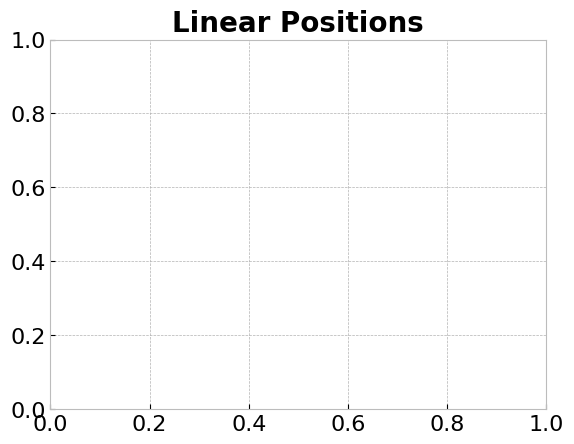

In [ ]:
print("\n")
print("plot results ...\n\n")

plt.figure()
plt.style.use('bmh')  
plt.rcParams.update({'font.size': 16})  
plt.tight_layout()

plt.gca().set_facecolor('white')  # Axes background
plt.gcf().set_facecolor('white')  # Figure background

plt.title("Linear Positions", fontsize=20, fontweight='bold')  # Bold and larger title
plt.plot(t, Xd[:-1, 8], linestyle='-.', color='darkgreen', label=r"$X_d$", linewidth=1.5)  # Dark green
plt.plot(t, Xs[:, 8], linestyle='-', color='navy', label="X", linewidth=2.5)  # Navy blue
plt.plot(t, Xd[:-1, 10], linestyle='--', color='gold', label=r"$Y_d$", linewidth=1.5)  # Gold
plt.plot(t, Xs[:, 10], linestyle='-', color='crimson', label="Y", linewidth=2.5)  # Crimson

plt.xlabel('Time (sec)', fontsize=16, labelpad=10)  # Add padding for clarity
plt.ylabel("Altitude (m)", fontsize=16, labelpad=10)
plt.grid(visible=True, which='both', linestyle=':', linewidth=0.7)  # Add grid with lighter style
plt.legend(loc='upper right', fontsize=14, frameon=True, shadow=True, fancybox=True)  # Enhanced legend at top-right

# plt.savefig('Position_xy_constant5', dpi=1200)
plt.show()


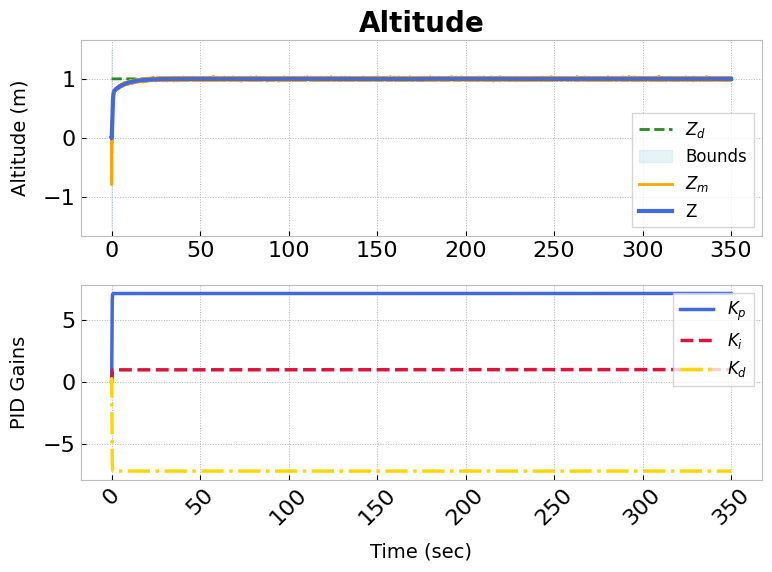

In [ ]:
# %%--------------------  Altitude ----------------------------------------#
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=False)  # Separate axes, no shared x-axis
plt.style.use('default')  # Use default style for a clean, white background
plt.rcParams.update({'font.size': 16})  # Adjust font size

# Set white background for figure and axes
fig.patch.set_facecolor('white')  # White background for the entire figure
ax1.set_facecolor('white')       # White background for the top plot
ax2.set_facecolor('white')       # White background for the bottom plot

# Top plot: Altitude
ax1.set_title("Altitude", fontsize=20, fontweight='bold')
ax1.plot(t, Xd[0:-1, 6], linestyle='--', color='forestgreen', label=r"$Z_d$", linewidth=2)  # Forest green for Z_d
ax1.fill_between(t, z_lower, z_upper, color='lightblue', alpha=0.3, label="Bounds")  # Light blue for bounds
ax1.plot(t, z_m, linestyle='-', color='orange', label=r"$Z_m$", linewidth=2)  # Orange for Z_m
ax1.plot(t, Xs[:, 6], linestyle='-', color='royalblue', label="Z", linewidth=3)  # Royal blue for Z
ax1.set_ylabel("Altitude (m)", fontsize=14, labelpad=10)
ax1.legend(loc="lower right", fontsize=12, frameon=True, shadow=False, fancybox=False)  # Simple legend
ax1.grid(visible=True, which='both', linestyle=':', linewidth=0.7)

# Bottom plot: PID Gains
ax2.plot(t, Kp_z[1:] - Kp_z_static, linestyle='-', color='royalblue', label=r"$K_p$", linewidth=2.5)  # Royal blue for K_p
ax2.plot(t, Ki_z[1:] - Ki_z_static, linestyle='--', color='crimson', label=r"$K_i$", linewidth=2.5)  # Crimson for K_i
ax2.plot(t, Kd_z[1:] - Kd_z_static, linestyle='-.', color='gold', label=r"$K_d$", linewidth=2.5)  # Gold for K_d
ax2.set_xlabel('Time (sec)', fontsize=14, labelpad=10)
ax2.set_ylabel("PID Gains", fontsize=14, labelpad=10)
ax2.legend(loc="upper right", fontsize=12, frameon=True, shadow=False, fancybox=False)  # Simple legend
ax2.grid(visible=True, which='both', linestyle=':', linewidth=0.7)

# Rotate x-axis labels for clarity (if needed)
ax2.tick_params(axis='x', rotation=45)

# Adjust layout to avoid overlapping elements
plt.tight_layout()

# Save or show the figure
# plt.savefig('Altitude_constant6', dpi=1200)
plt.show()


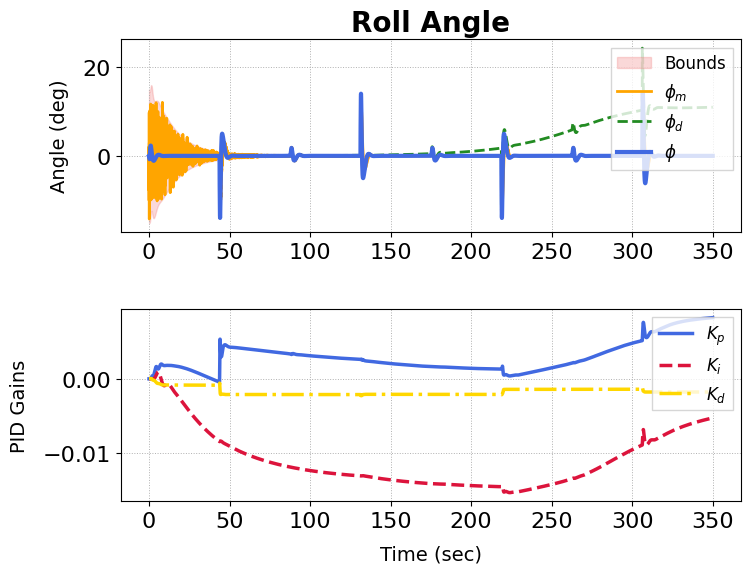

In [ ]:
# %%--------------------  phi ----------------------#
import matplotlib.pyplot as plt
import numpy as np

# Create figure and subplots with separate axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6), gridspec_kw={'hspace': 0.4})
plt.style.use('default')  # Use default style for a clean, white background
plt.rcParams.update({'font.size': 16})  # Adjust font size

# Set white background for the figure
fig.patch.set_facecolor('white')  # Ensure white figure background

# Top plot: Roll Angle
ax1.set_title("Roll Angle", fontsize=20, fontweight='bold')
ax1.fill_between(t, phi_lower, phi_upper, color='lightcoral', alpha=0.3, label="Bounds")  # Light coral for bounds
ax1.plot(t, np.rad2deg(phi_m), linestyle='-', color='orange', label=r"$\phi_m$", linewidth=2)  # Orange for phi_m
ax1.plot(t, np.rad2deg(Xd[0:-1, 0]), linestyle='--', color='forestgreen', label=r"$\phi_d$", linewidth=2)  # Forest green for phi_d
ax1.plot(t, np.rad2deg(Xs[:, 0]), linestyle='-', color='royalblue', label=r"$\phi$", linewidth=3)  # Royal blue for phi
ax1.set_ylabel("Angle (deg)", fontsize=14, labelpad=10)
ax1.legend(loc="upper right", fontsize=12, frameon=True, shadow=False, fancybox=False)  # Simple legend
ax1.grid(visible=True, linestyle=':', linewidth=0.7)  # Add grid to the top plot

# Bottom plot: PID Gains
ax2.plot(t, Kp_phi[1:] - Kp_phi_static, linestyle='-', color='royalblue', label=r"$K_p$", linewidth=2.5)  # Royal blue for K_p
ax2.plot(t, Ki_phi[1:] - Ki_phi_static, linestyle='--', color='crimson', label=r"$K_i$", linewidth=2.5)  # Crimson for K_i
ax2.plot(t, Kd_phi[1:] - Kd_phi_static, linestyle='-.', color='gold', label=r"$K_d$", linewidth=2.5)  # Gold for K_d
ax2.set_xlabel('Time (sec)', fontsize=14, labelpad=10)
ax2.set_ylabel("PID Gains", fontsize=14, labelpad=10)
ax2.legend(loc="upper right", fontsize=12, frameon=True, shadow=False, fancybox=False)  # Simple legend
ax2.grid(visible=True, linestyle=':', linewidth=0.7)  # Add grid to the bottom plot

# Save or display the plot
# plt.savefig('roll_constant4', dpi=1200)
plt.show()


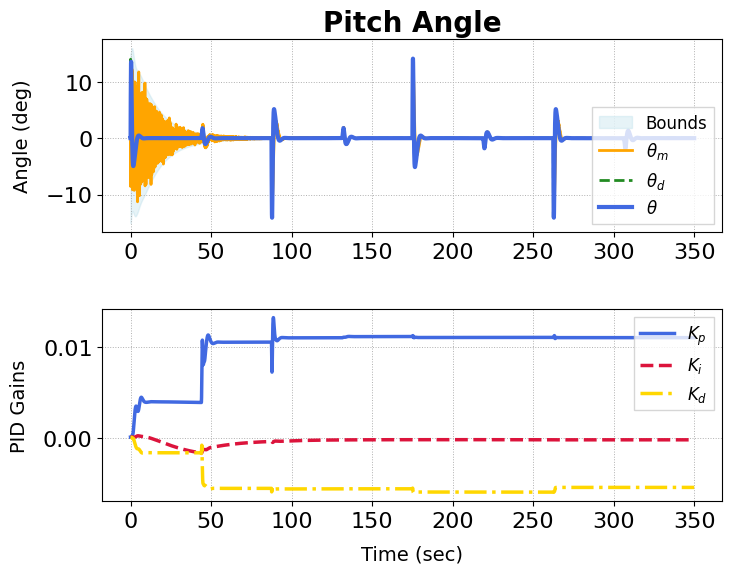

In [ ]:
# %%--------------------  tta ----------------------#
import matplotlib.pyplot as plt
import numpy as np

# Create figure and subplots with separate axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6), gridspec_kw={'hspace': 0.4})
plt.style.use('default')  # Use default style for a clean, white background
plt.rcParams.update({'font.size': 16})  # Adjust font size

# Set white background for the figure
fig.patch.set_facecolor('white')  # Ensure white figure background

# Top plot: Pitch Angle
ax1.set_title("Pitch Angle", fontsize=20, fontweight='bold')
ax1.fill_between(t, tta_lower, tta_upper, color='lightblue', alpha=0.3, label="Bounds")  # Light blue for bounds
ax1.plot(t, np.rad2deg(tta_m), linestyle='-', color='orange', label=r"$\theta_m$", linewidth=2)  # Orange for θ_m
ax1.plot(t, np.rad2deg(Xd[0:-1, 2]), linestyle='--', color='forestgreen', label=r"$\theta_d$", linewidth=2)  # Forest green for θ_d
ax1.plot(t, np.rad2deg(Xs[:, 2]), linestyle='-', color='royalblue', label=r"$\theta$", linewidth=3)  # Royal blue for θ
ax1.set_ylabel("Angle (deg)", fontsize=14, labelpad=10)
ax1.legend(loc="lower right", fontsize=12, frameon=True, shadow=False, fancybox=False)  # Simple legend
ax1.grid(visible=True, linestyle=':', linewidth=0.7)  # Add grid to the top plot

# Bottom plot: PID Gains
ax2.plot(t, Kp_tta[1:] - Kp_tta_static, linestyle='-', color='royalblue', label=r"$K_p$", linewidth=2.5)  # Royal blue for K_p
ax2.plot(t, Ki_tta[1:] - Ki_tta_static, linestyle='--', color='crimson', label=r"$K_i$", linewidth=2.5)  # Crimson for K_i
ax2.plot(t, Kd_tta[1:] - Kd_tta_static, linestyle='-.', color='gold', label=r"$K_d$", linewidth=2.5)  # Gold for K_d
ax2.set_xlabel('Time (sec)', fontsize=14, labelpad=10)
ax2.set_ylabel("PID Gains", fontsize=14, labelpad=10)
ax2.legend(loc="upper right", fontsize=12, frameon=True, shadow=False, fancybox=False)  # Simple legend
ax2.grid(visible=True, linestyle=':', linewidth=0.7)  # Add grid to the bottom plot

# Save or display the plot
# plt.savefig('pitch_constant6', dpi=1200)
plt.show()


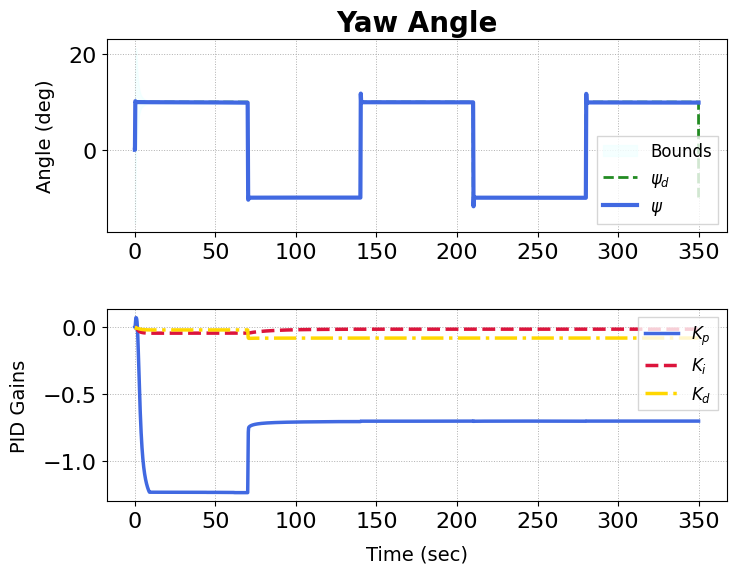

In [ ]:
# %%--------------------  psi ----------------------#
import matplotlib.pyplot as plt
import numpy as np

# Create figure and subplots with separate axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6), gridspec_kw={'hspace': 0.4})
plt.style.use('default')  # Use default style for a clean, white background
plt.rcParams.update({'font.size': 16})  # Adjust font size

# Set white background for the figure
fig.patch.set_facecolor('white')  # Ensure white figure background

# Top plot: Yaw Angle
ax1.set_title("Yaw Angle", fontsize=20, fontweight='bold')
ax1.fill_between(t, psi_lower, psi_upper, color='lightcyan', alpha=0.3, label="Bounds")  # Light cyan for bounds
# ax1.plot(t, np.rad2deg(psi_m), linestyle='-', color='orange', label=r"$\psi_m$", linewidth=2)  # Orange for ψ_m (if needed)
ax1.plot(t, np.rad2deg(Xd[0:-1, 4]), linestyle='--', color='forestgreen', label=r"$\psi_d$", linewidth=2)  # Forest green for ψ_d
ax1.plot(t, np.rad2deg(Xs[:, 4]), linestyle='-', color='royalblue', label=r"$\psi$", linewidth=3)  # Royal blue for ψ
ax1.set_ylabel("Angle (deg)", fontsize=14, labelpad=10)
ax1.legend(loc="lower right", fontsize=12, frameon=True, shadow=False, fancybox=False)  # Simple legend
ax1.grid(visible=True, linestyle=':', linewidth=0.7)  # Add grid to the top plot

# Bottom plot: PID Gains
ax2.plot(t, Kp_psi[1:] - Kp_psi_static, linestyle='-', color='royalblue', label=r"$K_p$", linewidth=2.5)  # Royal blue for K_p
ax2.plot(t, Ki_psi[1:] - Ki_psi_static, linestyle='--', color='crimson', label=r"$K_i$", linewidth=2.5)  # Crimson for K_i
ax2.plot(t, Kd_psi[1:] - Kd_psi_static, linestyle='-.', color='gold', label=r"$K_d$", linewidth=2.5)  # Gold for K_d
ax2.set_xlabel('Time (sec)', fontsize=14, labelpad=10)
ax2.set_ylabel("PID Gains", fontsize=14, labelpad=10)
ax2.legend(loc="upper right", fontsize=12, frameon=True, shadow=False, fancybox=False)  # Simple legend
ax2.grid(visible=True, linestyle=':', linewidth=0.7)  # Add grid to the bottom plot

# Save or display the plot
# plt.savefig('yaw_constant3', dpi=1200)
plt.show()


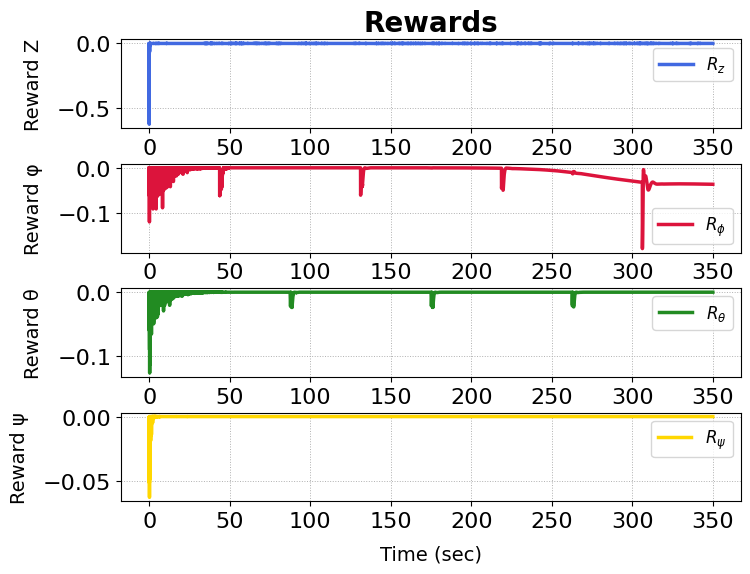

In [ ]:
# %%--------------------  Rewards ----------------------#
import matplotlib.pyplot as plt

# Create figure and subplots
fig, axs = plt.subplots(4, 1, figsize=(8,6), gridspec_kw={'hspace': 0.4})
plt.style.use('default')  # Use default style for a clean, white background
plt.rcParams.update({'font.size': 16})  # Adjust font size

# Set white background for the figure
fig.patch.set_facecolor('white')  # Ensure white figure background

# Top subplot: Reward for Z
axs[0].set_title("Rewards", fontsize=20, fontweight='bold')
axs[0].plot(t, R_z[:-1], color='royalblue', linestyle='-', label=r'$R_z$', linewidth=2.5)  # Royal blue for R_z
axs[0].set_ylabel('Reward Z', fontsize=14, labelpad=10)
axs[0].legend(loc="best", fontsize=12, frameon=True)
axs[0].grid(visible=True, linestyle=':', linewidth=0.7)

# Second subplot: Reward for φ
axs[1].plot(t, R_phi[:-1], color='crimson', linestyle='-', label=r'$R_\phi$', linewidth=2.5)  # Crimson for R_phi
axs[1].set_ylabel('Reward φ', fontsize=14, labelpad=10)
axs[1].legend(loc="best", fontsize=12, frameon=True)
axs[1].grid(visible=True, linestyle=':', linewidth=0.7)

# Third subplot: Reward for θ
axs[2].plot(t, R_tta[:-1], color='forestgreen', linestyle='-', label=r'$R_\theta$', linewidth=2.5)  # Forest green for R_theta
axs[2].set_ylabel('Reward θ', fontsize=14, labelpad=10)
axs[2].legend(loc="best", fontsize=12, frameon=True)
axs[2].grid(visible=True, linestyle=':', linewidth=0.7)

# Bottom subplot: Reward for ψ
axs[3].plot(t, R_psi[:-1], color='gold', linestyle='-', label=r'$R_\psi$', linewidth=2.5)  # Gold for R_psi
axs[3].set_xlabel('Time (sec)', fontsize=14, labelpad=10)
axs[3].set_ylabel('Reward ψ', fontsize=14, labelpad=10)
axs[3].legend(loc="best", fontsize=12, frameon=True)
axs[3].grid(visible=True, linestyle=':', linewidth=0.7)

# Save or display the plot
# plt.savefig('R_constant1', dpi=1200)
plt.show()


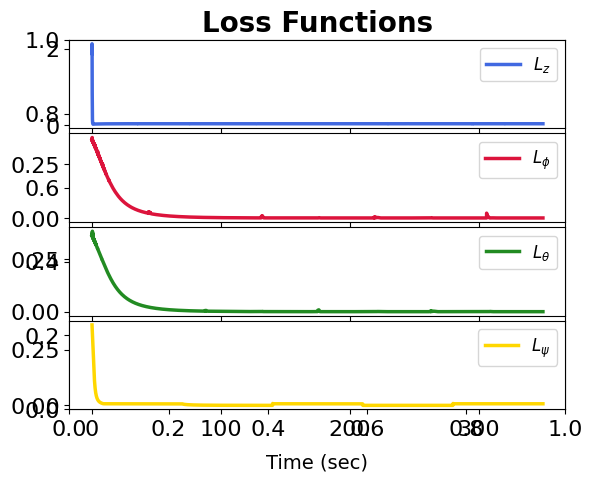

In [ ]:
# %%--------------------  Loss Functions ----------------------#
plt.figure()
plt.style.use('default')  # Use default style for a clean, white background
plt.rcParams.update({'font.size': 16})  # Adjust font size
plt.tight_layout()

# Set white background
plt.gca().set_facecolor('white')  # Ensure white axes background
plt.gcf().set_facecolor('white')  # Ensure white figure background

# Create subplots
plt1 = plt.subplot2grid((12, 1), (0, 0), rowspan=3, colspan=1)
plt2 = plt.subplot2grid((12, 1), (3, 0), rowspan=3, colspan=1)
plt3 = plt.subplot2grid((12, 1), (6, 0), rowspan=3, colspan=1)
plt4 = plt.subplot2grid((12, 1), (9, 0), rowspan=3, colspan=1)

# Top subplot: Loss for Z
plt1.set_title("Loss Functions", fontsize=20, fontweight='bold')
plt1.plot(t, z_agent_losses, color='royalblue', linestyle='-', label=r'$L_z$', linewidth=2.5)  # Royal blue for L_z
plt1.set_xticklabels([])
plt1.legend(loc="best", fontsize=12, frameon=True)

# Second subplot: Loss for φ
plt2.plot(t, phi_agent_losses, color='crimson', linestyle='-', label=r'$L_\phi$', linewidth=2.5)  # Crimson for L_phi
plt2.set_xticklabels([])
plt2.legend(loc="best", fontsize=12, frameon=True)

# Third subplot: Loss for θ
plt3.plot(t, tta_agent_losses, color='forestgreen', linestyle='-', label=r'$L_\theta$', linewidth=2.5)  # Forest green for L_theta
plt3.set_xticklabels([])
plt3.legend(loc="best", fontsize=12, frameon=True)

# Bottom subplot: Loss for ψ
plt4.plot(t, psi_agent_losses, color='gold', linestyle='-', label=r'$L_\psi$', linewidth=2.5)  # Gold for L_psi
plt4.set_xlabel('Time (sec)', fontsize=14, labelpad=10)
plt4.legend(loc="best", fontsize=12, frameon=True)

# plt.savefig('Loss_constant1', dpi=1200)
plt.show()


In [ ]:
# # %% Save Data
# from save_data import save_data
# self_tuning = 1
# if self_tuning == 1:
#     filename = "saved_data\\A2C_PID_data_with_square_path"
# else:
#     filename = "saved_data\\PID_data_with_Guassian_Dist_seed2"

# # with open(filename+"1.npy", 'wb') as f:
# #     np.save(f,Xs)

# Save_data(filename+"7th_bahman.xls", t, Xs, Xd, M)

In [ ]:
print("done!")

done!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Define parameters
N = 100  # Number of points
Tf = 10  # Final time
t = np.linspace(0, Tf, N)  # Time vector

# Initialize Xd
Xd = np.zeros((N, 12))

# Define Square Path
Xd[:, 4] = np.deg2rad(10 * signal.square(5 * np.pi / Tf * t))  # Yaw
Xd[:, 6] = 1  # Constant altitude
Xd[:, 8] = 1 + signal.square(4 * np.pi / Tf * t)  # X-axis
Xd[:, 10] = 1 + signal.square(4 * np.pi / Tf * (t - Tf / 8))  # Y-axis

# Extract path
x_path = Xd[:, 8]
y_path = Xd[:, 10]
z_path = Xd[:, 6]

# Plot the path in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_path, y_path, z_path, label='Square Path', color='b', linewidth=2)

# Labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z (Altitude)')
ax.set_title('3D Square Path')

# Show plot
plt.legend()
plt.show()


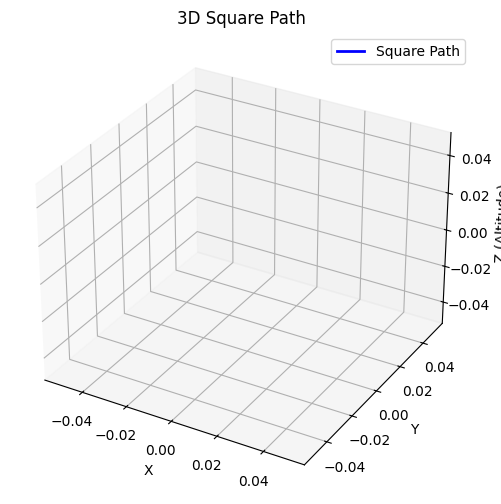

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(Xd[:, 8], Xd[:, 10], Xd[:, 6], label='Square Path', color='b', linewidth=2)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z (Altitude)')
ax.set_title('3D Square Path')

plt.legend()
plt.show()
